# EN3160 Assignment 2 on Fitting and Alignment

## Task 1


Detected Largest Circle Parameters:
Radius: 32.00000000000002
Center Coordinates: (359, 228)

Sigma Value Range:
Minimum Sigma: 0.5
Maximum Sigma: 64.00000000000006


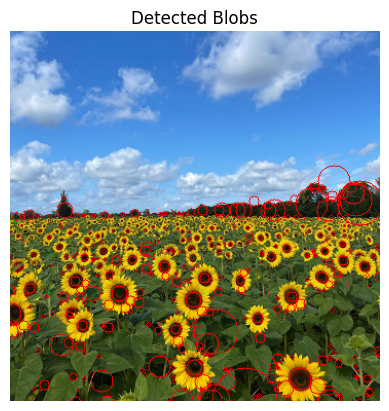

In [115]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the Laplacian of Gaussian (LoG) kernel
def generate_log_filter(sigma):
        hw = int(3 * sigma + 1)  # Ensure hw is an integer
        x = np.linspace(-hw, hw, 2 * hw + 1)  # Generate evenly spaced values for x
        y = np.linspace(-hw, hw, 2 * hw + 1)  # Generate evenly spaced values for y

        X, Y = np.meshgrid(x, y)  # Create a meshgrid of X and Y coordinates
        temp = -(X**2 + Y**2) / (2 * sigma**2)  # Compute the exponent term
        gauss_kernel = np.exp(temp)  # Compute Gaussian kernel
        gauss_kernel[gauss_kernel < np.finfo(float).eps * np.amax(gauss_kernel)] = 0  # Eliminate small values
        
        if np.sum(gauss_kernel) != 0:
            gauss_kernel /= np.sum(gauss_kernel)  # Normalize the kernel

        log_filter = (X**2 + Y**2 - 2 * sigma**2) * gauss_kernel / (sigma**4)  # Compute the LoG filter

        return log_filter



# Read image
image = cv.imread("the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)

# Convert image to grayscale and normalize
grayscale_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convert to grayscale
grayscale_img = np.float32(grayscale_img)  # Convert to float32
cv.normalize(grayscale_img, grayscale_img, 1, 0, cv.NORM_MINMAX)  # Normalize grayscale image

# Set parameters for the LoG scale-space
initial_sigma = 0.5 # Initial sigma value
scale_factor = np.sqrt(2)  # Scaling factor between subsequent layers
num_layers = 15  # Number of scales
sigma_values = initial_sigma * np.power(scale_factor, np.arange(num_layers))  # List of sigma values for each scale

# Perform LoG filtering at different scales
image_stack = None

for scale in range(num_layers):

        log_filter = generate_log_filter(sigma_values[scale]) * np.power(sigma_values[scale], 2)  # Generate LoG filter
        filtered_img = cv.filter2D(grayscale_img, cv.CV_32F, log_filter)  # Apply LoG filter
        filtered_img = pow(filtered_img, 2)  # Square the filtered image to enhance contrast
        
        # Stack filtered images
        if scale == 0:
                image_stack = filtered_img
        else:
                image_stack = np.dstack((image_stack, filtered_img)) 

# Extract the maximum response from the filtered images
max_response_space = None 

for scale in range(num_layers):
        filtered_max = cv.dilate(image_stack[:, :, scale], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT)  # Dilate filtered images
        
        if scale == 0:
                max_response_space = filtered_max
        else:
                max_response_space = np.dstack((max_response_space, filtered_max))

# Identify the maximum response across all scales
max_response_stack = np.amax(max_response_space, axis=2)  # Max across all scales
max_response_stack = np.repeat(max_response_stack[:, :, np.newaxis], num_layers, axis=2)  # Repeat for each scale
max_response_stack = np.multiply((max_response_stack == max_response_space), max_response_space)  # Retain only maximum responses

# Initialize vectors to store circle properties
radius_vector = None
x_coords = None
y_coords = None

for scale in range(num_layers):
        current_radius = np.sqrt(2) * sigma_values[scale]  # Calculate radius for current scale
        response_threshold = 0.01 # Threshold for maximum response
        valid_responses = (max_response_stack[:, :, scale] == image_stack[:, :, scale]) * image_stack[:, :, scale]  # Retain valid maximum responses
        valid_responses[valid_responses <= response_threshold] = 0  # Remove weak responses
        (x_points, y_points) = np.nonzero(valid_responses)  # Get coordinates of valid points
        
        if scale == 1:
                x_coords = x_points
                y_coords = y_points
                radius_vector = np.repeat(current_radius, np.size(x_points))  # Set radius vector for initial points
        else:
                x_coords = np.concatenate((x_coords, x_points), axis=None)
                y_coords = np.concatenate((y_coords, y_points), axis=None)
                radius_vector = np.concatenate((radius_vector, np.repeat(current_radius, np.size(x_points))), axis=None)

# Find the parameters of the largest detected circle
largest_radius = np.max(radius_vector)
largest_circle_idx = np.argmax(radius_vector)
largest_x = x_coords[largest_circle_idx]
largest_y = y_coords[largest_circle_idx]

# Report the parameters of the largest detected circle
print("\nDetected Largest Circle Parameters:")
print(f"Radius: {largest_radius}")
print(f"Center Coordinates: ({largest_x}, {largest_y})")

# Display the range of sigma values used
min_sigma_value = np.min(sigma_values)
max_sigma_value = np.max(sigma_values)
print(f"\nSigma Value Range:")
print(f"Minimum Sigma: {min_sigma_value}")
print(f"Maximum Sigma: {max_sigma_value}")

# Visualize the detected blobs (circles) on the image
output_image = image.copy()

for i in range(np.size(x_coords)):
       cv.circle(output_image, (y_coords[i], x_coords[i]), int(radius_vector[i]), (0, 0, 255), 1) 

# Display result using Matplotlib
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title("Detected Blobs")
plt.axis('off')
plt.show()


## Task 2

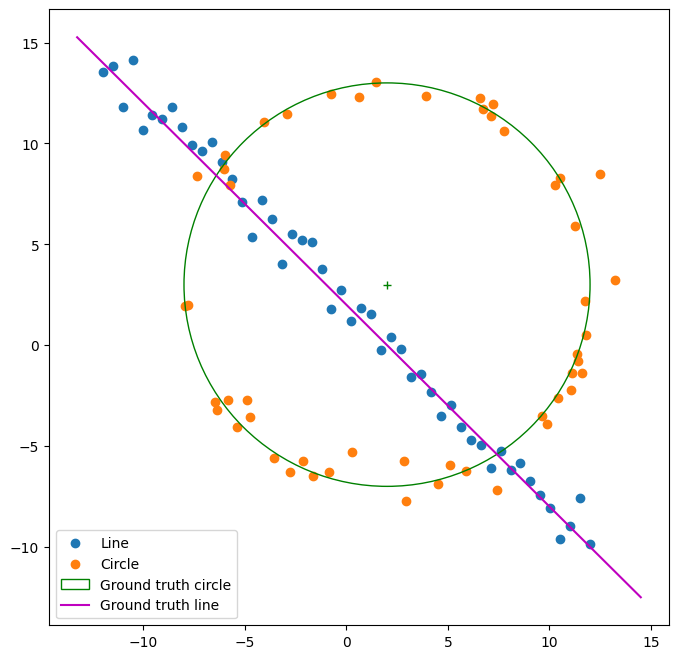

In [22]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
#import tikzplotlib
import numpy as np

# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b

plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()


Best Line Parameters: a = -0.7080986693010423, b = -0.7061134997534697, d = -1.530371730198251


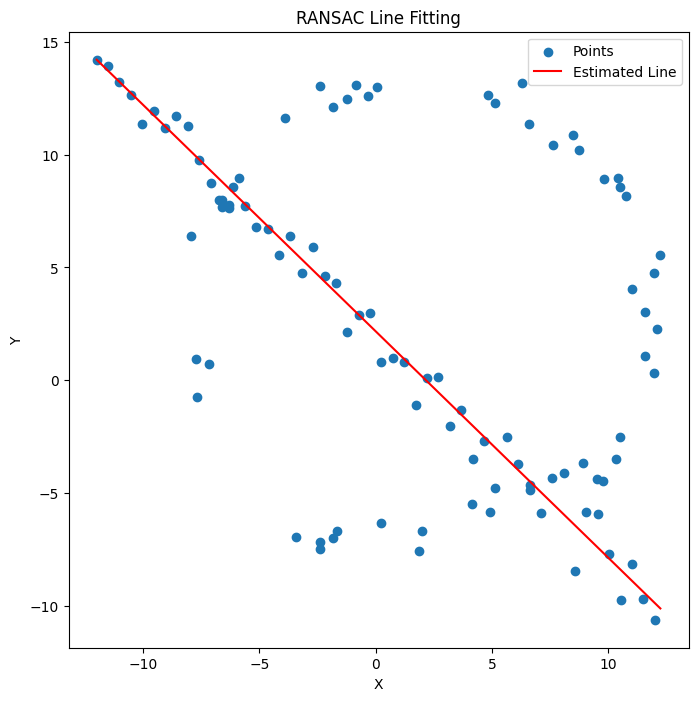

In [39]:
import math

def find_line_parameters_using_2_points(x1,y1,x2,y2):
        
        m = (y2-y1)/(x2-x1)
        c = y1 - m*x1
        
        a = m
        b = -1
        d = -c
        
        a_normalized = a/math.sqrt(a**2+b**2)
        b_normalized = b/math.sqrt(a**2+b**2)
        d_normalized = d/math.sqrt(a**2+b**2)
        
        return a_normalized,b_normalized,d_normalized

def RANSAC_line_fitting(X, iterations, threshold, min_inliers):

    best_model = None
    best_inliers = []

    for i in range(iterations):
        
        sample_indices = np.random.choice(len(X),2,replace=False)
        x1,y1 = X[sample_indices[0]]
        x2,y2 = X[sample_indices[1]]
        
        a,b,d = find_line_parameters_using_2_points(x1,y1,x2,y2)
        
        magnitude = np.sqrt(a**2 + b**2)
        a = a/magnitude
        b = b/magnitude

        distances = np.abs(a*X[:,0]+b*X[:,1]-d)

        inliers  = np.where(distances<threshold)[0]

        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model   = (a,b,d)
                best_inliers = inliers

    return best_model,best_inliers

# Parameters for RANSAC
iterations = 100000
threshold = 0.2
min_inliers = 15

# Run RANSAC to find the best line
best_model, best_inliers = RANSAC_line_fitting(X, iterations, threshold, min_inliers)

# Extract the parameters of the best line (a, b, d)
a, b, d = best_model

# Display the parameters of the best line
print(f"Best Line Parameters: a = {a}, b = {b}, d = {d}")

# Define the line: ax + by = d -> y = (-a/b)x + (d/b)
slope = -a / b
intercept = d / b

# Generate x values for plotting the line
x_values = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
y_values = slope * x_values + intercept

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Points')

# Plot the best fitting line
ax.plot(x_values, y_values, color='red', label='Estimated Line')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('RANSAC Line Fitting')

# Show the plot
plt.show()



Detected Circle Parameters:
Center Coordinates: (2.1833812744889824, 2.8183549018592795)
Radius: 10.081626475067782


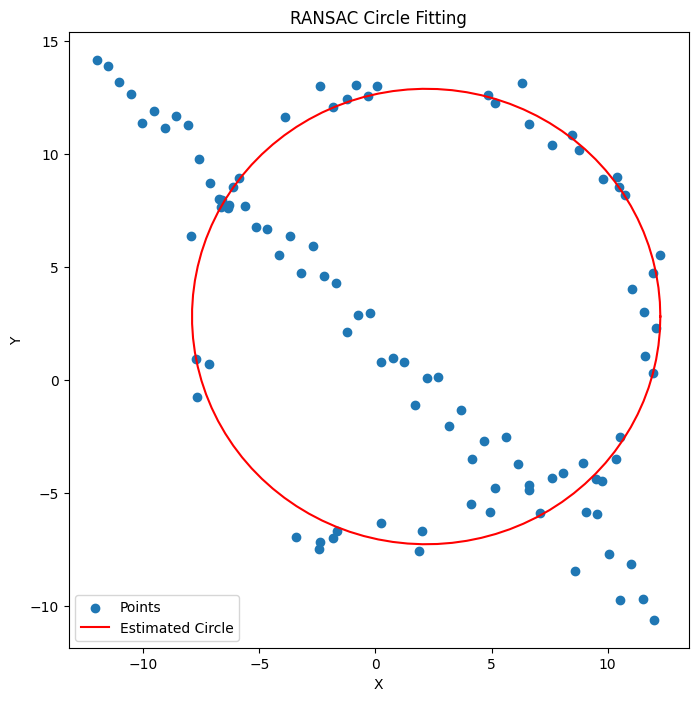

In [40]:
def find_circle_parameters_using_3_points(x1,y1,x2,y2,x3,y3):

    mx1,my1 = (x1+x2)/2,(y1+y2)/2
    mx2,my2 = (x2+x3)/2,(y2+y3)/2

    if y2-y1 == 0:
        slope1 = 0 
    else:
        slope1 = (x2-x1)/(y2-y1)

    if y3-y2 == 0:
        slope2 = 0 
    else:
        slope2 = (x3-x2)/(y3-y2)

    x_center = (slope1*mx1-slope2*mx2+my2-my1)/(slope1-slope2)
    y_center = -slope1*(x_center-mx1)+my1

    radius = np.sqrt((x1-x_center)**2+(y1-y_center)**2)

    return x_center,y_center,radius


def RANSAC_circle_fitting(X,iterations,threshold,min_inliers):
    
    best_model   = None
    best_inliers = []
    
    for i in range(iterations):
        sample_indices = np.random.choice(len(X),3,replace=False)
        x1,y1 = X[sample_indices[0]]
        x2,y2 = X[sample_indices[1]]
        x3,y3 = X[sample_indices[2]]
        
        x_center,y_center,radius = find_circle_parameters_using_3_points(x1,y1,x2,y2,x3,y3)
        
        errors  = np.abs(np.sqrt((X[:,0]-x_center)**2+(X[:,1]-y_center)**2)-radius)
        
        inliers = np.where(errors<threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model   = (x_center,y_center,radius)
                best_inliers = inliers
                
    return best_model,best_inliers


# Parameters for RANSAC
iterations = 100000
threshold = 0.2
min_inliers = 1

# Run RANSAC to find the best circle
best_model, best_inliers = RANSAC_circle_fitting(X, iterations, threshold, min_inliers)

# Extract the parameters of the best circle (x_center, y_center, radius)
x_center, y_center, radius = best_model

# Display the parameters of the best circle
print("\nDetected Circle Parameters:")
print(f"Center Coordinates: ({x_center}, {y_center})")
print(f"Radius: {radius}")

# Generate angles for plotting the circle
theta = np.linspace(0, 2 * np.pi, 100)
x_values = x_center + radius * np.cos(theta)
y_values = y_center + radius * np.sin(theta)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Points')

# Plot the best fitting circle
ax.plot(x_values, y_values, color='red', label='Estimated Circle')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('RANSAC Circle Fitting')

# Show the plot
plt.show()



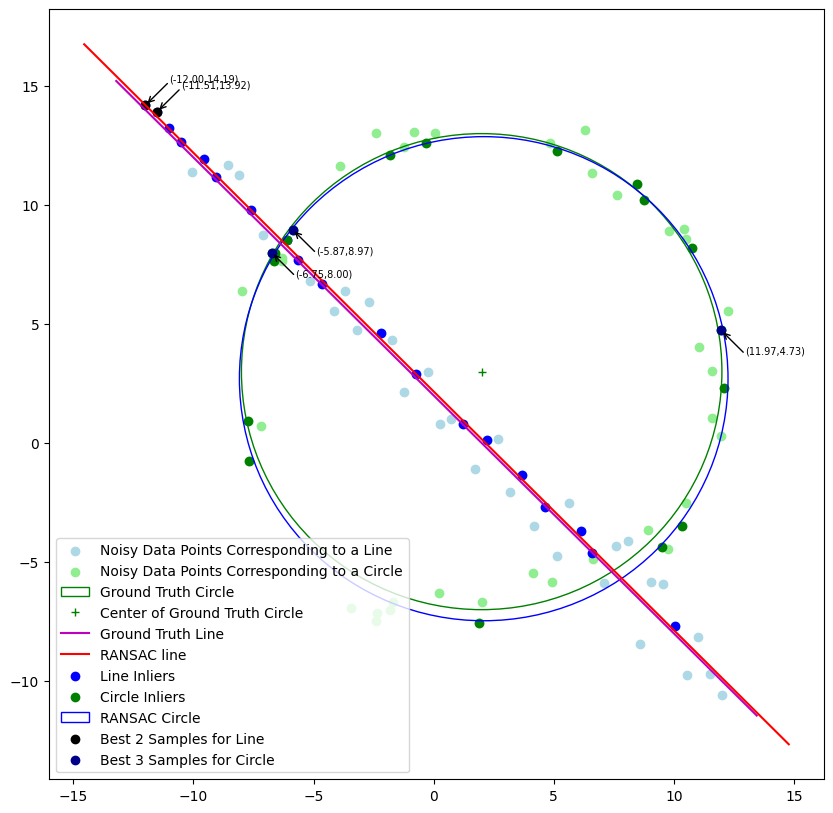

In [41]:
# Generate noisy data points corresponding to a circle and a line
np.random.seed(1)
N = 100
half_n = N//2
r = 10
x0_gt, y0_gt = 2,3  # Center 
s = r/16
t = np.random.uniform(0,2*np.pi,half_n)
n = s * np.random.randn(half_n)
x = x0_gt+(r+n)*np.cos(t)
y = y0_gt+(r+n)*np.sin(t)
X_circ = np.column_stack((x, y))
s = 1.0
m,b = -1,2
x = np.linspace(-12,12,half_n)
y = m*x+b+s*np.random.randn(half_n)
X_line = np.column_stack((x,y))
X = np.vstack((X_circ,X_line))
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(X_line[:,0],X_line[:,1],label='Noisy Data Points Corresponding to a Line',color='lightblue')
ax.scatter(X_circ[:,0],X_circ[:,1],label='Noisy Data Points Corresponding to a Circle',color='lightgreen')
circle_gt = plt.Circle((x0_gt,y0_gt),r,color='g',fill=False,label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt,y0_gt,'+',label='Center of Ground Truth Circle',color='g')
x_min,x_max = ax.get_xlim()
x_ = np.array([x_min,x_max])
y_ = m*x_+b
plt.plot(x_,y_,color='m',label='Ground Truth Line')




# RANSAC parameters for line estimation
iterations  = 100000
threshold   = 0.2
min_inliers = 15

# Estimate the line using RANSAC
best_RANSAC_line,line_inlier_indices_array = RANSAC_line_fitting(X_line,iterations,threshold,min_inliers)

# RANSAC parameters for circle estimation
circle_iterations  = 100000
circle_threshold   = 0.2  
circle_min_inliers = 15

remnant_indices = [i for i in range(len(X)) if i not in line_inlier_indices_array]
remnant_points  = X[remnant_indices]

# Estimate the circle using RANSAC
best_RANSAC_circle, circle_inlier_indices_array = RANSAC_circle_fitting(remnant_points,circle_iterations,circle_threshold,circle_min_inliers)

# Plot the line estimated by RANSAC
x_min,x_max = ax.get_xlim()
x_ = np.array([x_min,x_max])
y_ = (-best_RANSAC_line[0]*x_+best_RANSAC_line[2])/best_RANSAC_line[1]
plt.plot(x_,y_,label='RANSAC line',color='red')

# Plot the inliers of the line
ax.scatter(X_line[line_inlier_indices_array, 0],X_line[line_inlier_indices_array, 1],color='blue',label='Line Inliers')

# Find the best 2 samples for the line (using line_inlier_indices_array)
best_line_sample_indices = line_inlier_indices_array[:2]
best_line_samples = X_line[best_line_sample_indices]

ax.scatter(remnant_points[circle_inlier_indices_array,0],remnant_points[circle_inlier_indices_array,1],color='g',label='Circle Inliers')

# Plot the circle estimated by RANSAC
x_center,y_center,radius = best_RANSAC_circle
circle_estimated = plt.Circle((x_center,y_center),radius,color='blue',fill=False,label='RANSAC Circle')
ax.add_patch(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices_array)
best_circle_sample_indices = circle_inlier_indices_array[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]

# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:,0], best_line_samples[:,1],color='black',marker='o',label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:,0], best_circle_samples[:,1],color='darkblue',marker='o',label='Best 3 Samples for Circle')

# Annotations
def annotate_sample(ax,start,end,label):
        ax.annotate("",xy=start,xytext=end,arrowprops=dict(arrowstyle="->",color='black'))
        ax.text(end[0],end[1],label,fontsize=7,ha='left')
for i, sample in enumerate(best_line_samples):
        label = f'({sample[0]:.2f},{sample[1]:.2f})'
        annotate_sample(ax,(sample[0],sample[1]),(sample[0]+1,sample[1]+1),label)
for i, sample in enumerate(best_circle_samples):
        label = f'({sample[0]:.2f},{sample[1]:.2f})'
        annotate_sample(ax,(sample[0],sample[1]),(sample[0]+1,sample[1]-1),label)

plt.legend()
plt.show()


In [ ]:
#code

## Task 4

In [ ]:
#code